# Lab 1: image rectification

This lab has two main goals:

1) Get more familiar with the hierarchy of 2D transformation <br>

2) Remove the projective distortion of an image of a planar object (image rectification)

The following file combines some text cells (Markdown cells) and code cells. Some parts of the code need to be completed. All tasks you need to complete are marked in <span style='color:Green'> green.  </span>

In [ ]:
from PIL import Image, ImageDraw
import numpy as np
from scipy.ndimage import map_coordinates
from numpy import linalg as LA
from math import ceil
from utils import line_draw, plot_img, get_angle_lines, transform_lines, crop
import matplotlib.pyplot as plt
from typing import Tuple,List
from scipy.linalg import null_space,ldl
from scipy.linalg import cholesky

In [ ]:
def warp(H,p):
    """
    Warp a point based on a given Homography matrix
    
    Returns:
        Tuple of points
    """
    x1,x2 = p
    x1, x2, x3 = H @ np.array([x1,x2,1])
    if x3 != 0:
        return x1/x3, x2/x3
    return x1, x2

## **1. Applying image transformations**

In this first part of the lab you will apply different types of 2D transformations to a given image. For that, you first need to create a function that applies a homography to animage.

<span style='color:Green'> - Create the function  *apply_H* that gets as input a homography and
an image and returns the image transformed by the homography. </span>

Note: The size of the transformed image has to be automatically set so as to 
contain the whole transformed image.
You will need to interpolate the image values at some points, for that,
you may use the function *scipy.ndimage.map_coordinates*

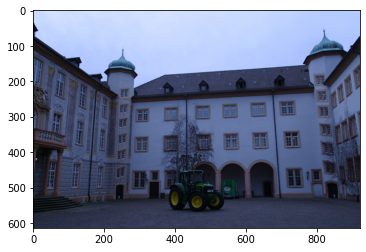

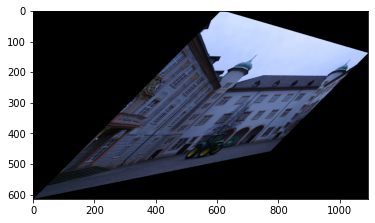

In [ ]:


def apply_H(I, H): 
    h,w,c = I.shape
    tl = warp(H,(0,0)) # top left
    tr = warp(H,(w,0)) # top right
    bl = warp(H,(0,h)) # bottom left
    br = warp(H,(w,h)) # bottom right
    corners = np.array([tl,tr,bl,br])

    #get min and max coordinates in the new space
    min_x = np.ceil(corners.min(axis=0)[0])
    max_x = np.floor(corners.max(axis=0)[0])
    min_y = np.ceil(corners.min(axis=0)[1])
    max_y = np.floor(corners.max(axis=0)[1])

    # get size of canvas
    width_canvas, height_canvas = max_x-min_x,max_y-min_y

    # generate a grid corresponding to new space coordinates
    xx,yy = np.meshgrid(np.arange(min_x,max_x),np.arange(min_y,max_y))

    # make a matrix with all new points in homogenous coordinates
    dstpointsH = np.array([xx.flatten(),yy.flatten(),np.ones_like(xx.flatten())])
    H_inv = LA.inv(H)
    # map them back to their source points
    # src_points = H_inv@dstpointsH
    src_points = np.matmul(H_inv,dstpointsH)

    # get src_x and src_y in meshgrid-like coordinates
    src_x = np.reshape(src_points[0]/src_points[2], xx.shape)
    src_y = np.reshape(src_points[1]/src_points[2], yy.shape)

    #draw canvas
    out = np.zeros((int(height_canvas),int(width_canvas),3))

    # using map_coordinates in by passing in a meshgrid is one of the best parts about this
    # function. You must be familiar with its input arguments to make the best use of it.
    for i in range(c):
        out[:,:,i] = map_coordinates(I[:,:,i],[src_y,src_x])
    return np.uint8(out)


img_path = "../../Data/0000_s.png"
I = Image.open(img_path)
H = np.array(((1,-1,-0), (0.3,1,10), (0.001,0,1)))
#H = np.array(((1,0,0), (0,1,0), (0,0,1)))
I_sim = apply_H(np.array(I), H)

plot_img(I)
plot_img(I_sim)

### **1.1 Similarities**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces a similarity transformation. </span>

In [ ]:
def build_similarity_matrix(theta, scale, translation):
    """
    Build a similarity matrix from rotation, scaling and translation
    
    Args:
        theta: angle in degrees
        scale: number to scale
        translation: list/tuple/array with corresponding
            x and y coordinates to translate the axes to
    """
    # convert to radians
    theta = theta*np.pi/180
    matrix = np.array([[np.cos(theta)*scale, -np.sin(theta)*scale, translation[0]],
                        [np.sin(theta)*scale, np.cos(theta)*scale, translation[1]],
                        [0,0,1]])
    return matrix

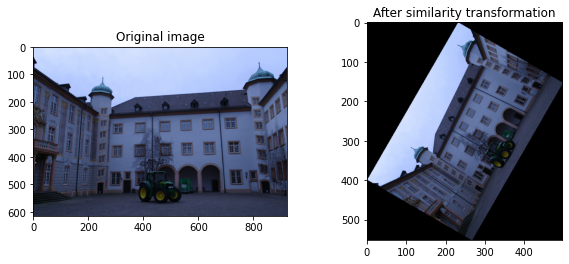

In [ ]:
img_path = "../../Data/0000_s.png"
I = Image.open(img_path)

theta = -60
scale = 0.5
trans = (20, 5)
sim_matrix = build_similarity_matrix(theta, scale, trans)

I_sim = apply_H(np.array(I), sim_matrix)

fig, ax = plt.subplots(1, 2)
fig.set_figwidth(10)
ax[0].set_title("Original image")
ax[0].imshow(I)
ax[1].set_title("After similarity transformation")
ax[1].imshow(I_sim)
plt.savefig("figures_german/similarity.pdf")

### **1.2 Affinities**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces an affine transformation.  </span>

<span style='color:Green'> - Decompose the affinity in four transformations: two
rotations, a scale, and a translation (you may use function *numpy.linalg.svd* for that).  </span>

<span style='color:Green'> - Verify that the product of the four previous transformations
produces the same matrix H as above.  </span>

<span style='color:Green'> - verify that the proper sequence of the four previous
transformations over the image I produces the same transformed image as before.  </span>

### Singular Value Decomposition 

$A=UDV^T$, such that $D$ is a diagonal matrix and $U$ and $V$ are orthogonal matrices.

Since $U$ and $V$ are orthogonal, A can be decomposed into rotations and non-isotropic scalings:

$UDV^T=(UV^T)(VDV^T)=R(\theta)(R(-\phi)DR(\phi))$

1. $R(\theta) = UV^T$

2. $R(\phi) = V^T$

In [ ]:
def build_affine_matrix(A, translation):
    """
    Build an affine matrix from a non-singular matrix A and translation t
    
    Args:
        A: a non-singular matrix A
        translation: list/tuple/array with corresponding
            x and y coordinates to translate the axes to
    """
    matrix = np.array([[A[0,0],A[0,1,], translation[0]],
                       [A[1,0], A[1,1], translation[1]],
                       [0,0,1]])
    return matrix

In [ ]:
A = np.array([[0.5, 0.3],[-0.6, 1]])
t = [5,10]
U,D,Vt = LA.svd(A)

R1 = U@Vt
R2 = Vt

Hrot1 = np.array([[R1[0,0], R1[0,1], 0],
                  [R1[1,0], R1[1,1], 0],
                  [0, 0, 1]])

Hrot2 = np.array([[R2[0,0], R2[0,1], 0],
                  [R2[1,0], R2[1,1], 0],
                  [0, 0, 1]])

Hscale = np.array([[D[0], 0, 0],
                   [0, D[1], 0],
                   [0, 0, 1]])

Htrans = np.array([[1, 0, t[0]],
                  [0, 1, t[1]],
                  [0, 0, 1]])

Hcombined = Htrans@Hrot1@(Hrot2.T)@Hscale@Hrot2

affine_matrix = build_affine_matrix(A, t)

print(f'A:\n{A}')
print(f"\nTranslation: {t}")
print("____________")
print(f"\n> Decomposition of A into fundamental transformations through SVD:\n")
print(f'Htrans:\n{Htrans}\n')
print(f'Hrot1:\n{Hrot1}\n')
print(f'Hrot2.T:\n{Hrot2.T}\n')
print(f'Hscale:\n{Hscale}\n')
print(f'Hrot2:\n{Hrot2}\n')
print("______\n")
print(f'Hcombined (multiplication of fundamental transformations matrices):\n{Hcombined}')

A:
[[ 0.5  0.3]
 [-0.6  1. ]]

Translation: [5, 10]
____________

> Decomposition of A into fundamental transformations through SVD:

Htrans:
[[ 1  0  5]
 [ 0  1 10]
 [ 0  0  1]]

Hrot1:
[[ 0.85749293  0.51449576  0.        ]
 [-0.51449576  0.85749293  0.        ]
 [ 0.          0.          1.        ]]

Hrot2.T:
[[-0.51449576  0.85749293  0.        ]
 [ 0.85749293  0.51449576  0.        ]
 [ 0.          0.          1.        ]]

Hscale:
[[1.16619038 0.         0.        ]
 [0.         0.58309519 0.        ]
 [0.         0.         1.        ]]

Hrot2:
[[-0.51449576  0.85749293  0.        ]
 [ 0.85749293  0.51449576  0.        ]
 [ 0.          0.          1.        ]]

______

Hcombined (multiplication of fundamental transformations matrices):
[[ 0.5  0.3  5. ]
 [-0.6  1.  10. ]
 [ 0.   0.   1. ]]


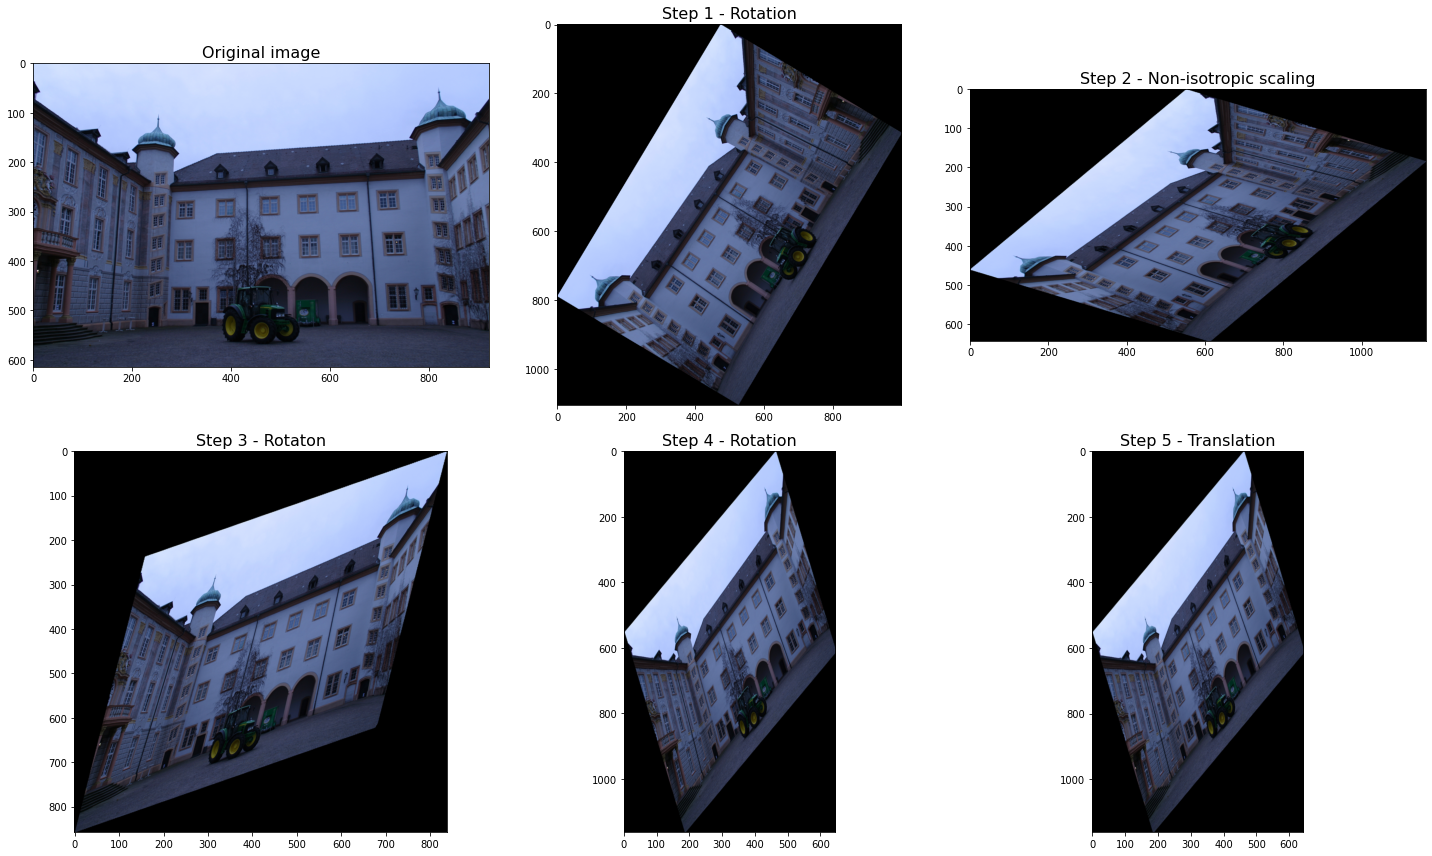

In [ ]:
I21 = apply_H(np.array(I),Hrot2)
I22 = crop(apply_H(np.array(I21),Hscale))
I23 = crop(apply_H(np.array(I22),Hrot2.T))
I24 = crop(apply_H(np.array(I23),Hrot1))
I25 = crop(apply_H(np.array(I24),Htrans))

I2 = apply_H(np.array(I), Hcombined)
I3 = apply_H(np.array(I),affine_matrix)

fig,axes = plt.subplots(2,3, figsize=(20,12))
titles = ['Original image','Step 1 - Rotation','Step 2 - Non-isotropic scaling','Step 3 - Rotaton','Step 4 - Rotation','Step 5 - Translation']
images = [np.array(I), I21, I22, I23, I24, I25]
for ax, image, title in zip(axes.flatten(), images, titles):
    ax.imshow(image)
    ax.set_title(title, fontsize=16)
plt.tight_layout()
plt.savefig("figures_german/affinity.pdf")
plt.show()

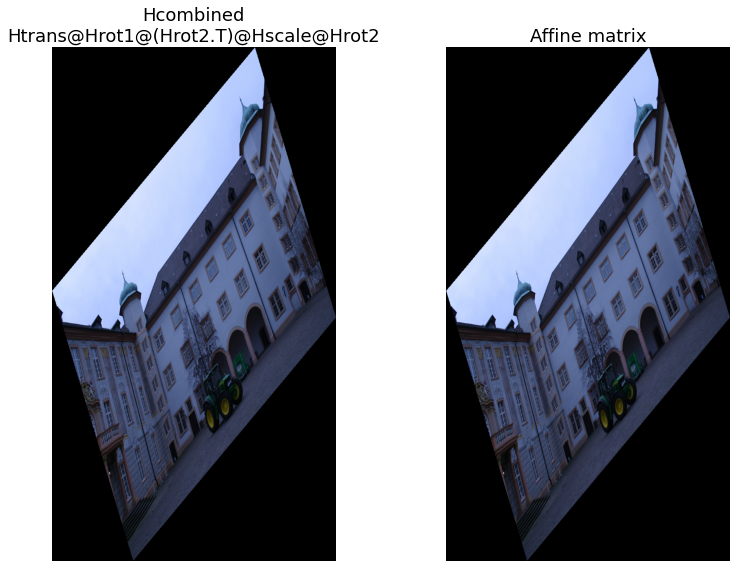

In [ ]:
fig,axes = plt.subplots(1,2, figsize=(12,8))
titles = ['Hcombined\nHtrans@Hrot1@(Hrot2.T)@Hscale@Hrot2', 'Affine matrix']
images = [I2, I3]
for ax, image, title in zip(axes.flatten(), images, titles):
    ax.imshow(image)
    ax.set_title(title, fontsize=18)
    ax.axis('off')
plt.tight_layout()
plt.show()

### **1.3 Projective transformations (Homographies)**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces a projective transformation.  </span>

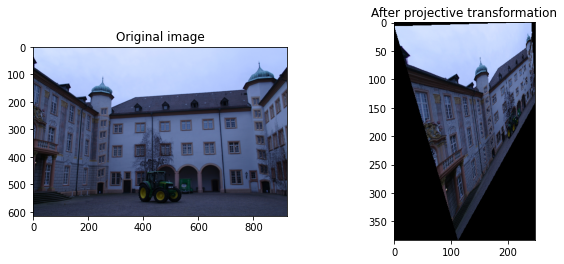

In [ ]:
def build_homography_matrix(A, translation, v):
    """
    Build a homography matrix from a non-singular matrix A, translation t and v
    
    Args:
        A: a non-singular matrix A
        translation: list/tuple/array with corresponding
            x and y coordinates to translate the axes to
    """
    matrix = np.array([[A[0,0],A[0,1,], translation[0]],
                       [A[1,0], A[1,1], translation[1]],
                       [v[0],v[1],1]])
    return matrix

A = np.array([[1, 0.3],[0, 1]])
t = [5,10]
v = [0.003, 0.001]

homography_matrix = build_homography_matrix(A,t,v);homography_matrix

I = Image.open('../../Data/0000_s.png')
I2 = apply_H(np.array(I), homography_matrix)

fig, ax = plt.subplots(1, 2)
fig.set_figwidth(10)
ax[0].set_title("Original image")
ax[0].imshow(I)
ax[1].set_title("After projective transformation")
ax[1].imshow(I2)
plt.savefig("figures_german/projectivity.pdf")

## **2. Affine Rectification**

This step is needed in order to rectify an image in a stratified way, where we first perform affine rectification (current section) and then metric rectification (Section 3).

In [ ]:
# load images and lines
img_path = "../../Data/0000_s.png"
I = Image.open(img_path)

lines_path = "../../Data/0000_s_info_lines.txt"
A = np.loadtxt(lines_path)

# points of interest
i = 423 # line index
p1 = [A[i, 0], A[i, 1], 1] # initial point in line i
p2 = [A[i, 2], A[i, 3], 1] # final point in line i
i = 239
p3 = [A[i, 0], A[i, 1], 1]
p4 = [A[i, 2], A[i, 3], 1]
i = 711
p5 = [A[i, 0], A[i, 1], 1]
p6 = [A[i, 2], A[i, 3], 1]
i = 564
p7 = [A[i, 0], A[i, 1], 1]
p8 = [A[i, 2], A[i, 3], 1]

<span style='color:Green'>The lines l1, l2, l3, l4, that pass through the different pairs of points are computed through scalar product. </span>

In [ ]:
l1 = np.cross(p1, p2)
l2 = np.cross(p3, p4)
l3 = np.cross(p5, p6)
l4 = np.cross(p7, p8)

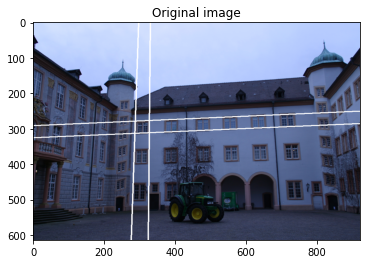

In [ ]:
# show the chosen lines in the image
canv = ImageDraw.Draw(I)

line_draw(l1, canv, I.size)
line_draw(l2, canv, I.size)
line_draw(l3, canv, I.size)
line_draw(l4, canv, I.size)

# The displayed lines will alter image I so we have to reopen the original image after the plot
plot_img(I)
plt.title('Original image')
I = Image.open(img_path)

Line at infinity is computed as the line passing through two _vanishing points_. This points are computed as the intersection between two parallel lines (once again, through cross product)

In [ ]:
# Compute vanishing points
vanish_pt1 = np.cross(l1, l2)
vanish_pt2 = np.cross(l3, l4)

# Compute and normalise line at infinity
line_inf = np.cross(vanish_pt1, vanish_pt2)
line_inf /= line_inf[2]

# Construct Homography which maps line_inf to [0, 0, 1]. We assume Ha is the identity.
H_affine_rect = np.eye(3)
H_affine_rect[2, :] = line_inf

Indeed, we have that $H_a^{-T}l = [0, 0, 1] $

In [ ]:
LA.inv(H_affine_rect.T)@line_inf

array([0., 0., 1.])

We now apply the homography to the whole image and to the selected lines (for checking they are still parallel)

Text(0.5, 1.0, 'Affine Rectification output')

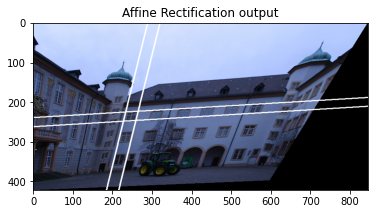

In [ ]:
I_aff_rect = apply_H(np.array(I), H_affine_rect)

# Get transformed lines 
H_aff_rect_lines = np.transpose(LA.inv(H_affine_rect))

lr1 = H_aff_rect_lines@l1
lr2 = H_aff_rect_lines@l2
lr3 = H_aff_rect_lines@l3
lr4 = H_aff_rect_lines@l4

#lr1,lr2,lr3,lr4 = transform_lines(H_affine_rect, [l1, l2, l3, l4])

I_aff_rect_draw = Image.fromarray(I_aff_rect.astype(np.uint8)) 
canv = ImageDraw.Draw(I_aff_rect_draw)

line_draw(lr1, canv, I.size)
line_draw(lr2, canv, I.size)
line_draw(lr3, canv, I.size)
line_draw(lr4, canv, I.size)

plot_img(I_aff_rect_draw)
plt.title('Affine Rectification output')


We can see that the transformed lines still look parallel. Let us now compute the angle for checking it strictly.

In [ ]:
# Check angles between lines 
# Expected after transform: l1 || l2, l3 || l4
# We only expect l1,l2 ┬ l3,l4 after metric rectification
print('Angles before transform')
print('θ(l1,l2) = ', get_angle_lines(l1, l2))
print('θ(l3,l4) = ', get_angle_lines(l3, l4))
print('θ(l1,l3) = ', get_angle_lines(l1, l3))

print('Angles after transform')
print('θ(lr1,lr2) = ', get_angle_lines(lr1, lr2))
print('θ(lr3,lr4) = ', get_angle_lines(lr3, lr4))
print('θ(lr1,lr3) = ', get_angle_lines(lr1, lr3))

Angles before transform
θ(l1,l2) =  0.09918160389665683
θ(l3,l4) =  1.3435373042187968
θ(l1,l3) =  85.45401946339824
Angles after transform
θ(lr1,lr2) =  0.0
θ(lr3,lr4) =  0.0
θ(lr1,lr3) =  72.64082077686572


As we can see, parallel lines (l1,l2 and l3, l4) remain parallel to each other. On the other hand, the angle between the two parallel set _does_ change, which was to be expected.

## **3. Metric Rectification**

### **3.1 Metric rectification after the affine rectification (stratified solution)**

<span style='color:Green'> - Write the code that performs the metric rectification (after the affine rectification). </span>

As qualitative evaluation method you can display the images (before and after the metric rectification) with the chosen lines printed on it.
      
<span style='color:Green'> - Compute the angles between the pair of lines before and after rectification. Comment the result. </span>
      


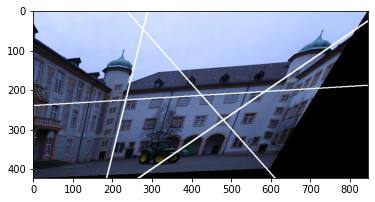

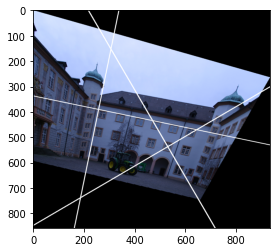

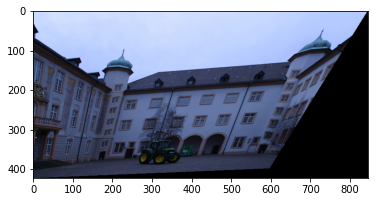

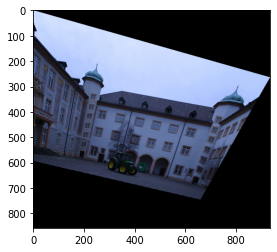

In [ ]:
#get non-parallel set of orhogonal lines

# points of interest
i = 423 # line index
p1 = [A[i, 0], A[i, 1], 1] # initial point in line i
p2 = [A[i, 2], A[i, 3], 1] # final point in line i

p3 = [A[533, 0], A[533, 1], 1]
p4 = [A[575, 0], A[575, 1], 1]
i = 711
p5 = [A[i, 0], A[i, 1], 1]
p6 = [A[i, 2], A[i, 3], 1]

p7 = [A[533, 2], A[533, 3], 1]
p8 = [A[575, 2], A[575, 3], 1]

l1 = np.cross(p1, p2)
l2 = np.cross(p3, p4)
l3 = np.cross(p5, p6)
l4 = np.cross(p7, p8)

lr1, lr2, lr3, lr4 = [np.transpose(LA.inv(H_affine_rect))@l for l in [l1, l2, l3, l4]]

lr1 /= lr1[2]
lr2 /= lr2[2]
lr3 /= lr3[2]
lr4 /= lr4[2]

# show the chosen lines in the affinely rectified image
I_draw = Image.fromarray(I_aff_rect.astype(np.uint8))
canv = ImageDraw.Draw(I_draw)

line_draw(lr2, canv, I_draw.size)
line_draw(lr4, canv, I_draw.size)
line_draw(lr1, canv, I_draw.size)
line_draw(lr3, canv, I_draw.size)

plot_img(I_draw)

# getting matrix S
eq = np.array([[lr1[0]*lr3[0], lr1[0]*lr3[1] + lr1[1]*lr3[0], lr1[1]*lr3[1]],\
               [lr2[0]*lr4[0], lr2[0]*lr4[1] + lr2[1]*lr4[0], lr2[1]*lr4[1]]])
s0 = null_space(eq)
S = np.array([s0[0],s0[1],s0[1],s0[2]]).reshape(2,2)

#getting matrix H
K = LA.cholesky(S)
Hm = np.eye(3)
Hm[:2,:2] = K
Hm = LA.inv(Hm)

#applying rectification
I_met_rect = apply_H(np.array(I_aff_rect), Hm)

lm1, lm2, lm3, lm4 = transform_lines(Hm, I_aff_rect, [lr1, lr2, lr3, lr4])

I_draw = Image.fromarray(I_met_rect.astype(np.uint8))
canv = ImageDraw.Draw(I_draw)

line_draw(lm2, canv, I_draw.size)
line_draw(lm4, canv, I_draw.size)
line_draw(lm1, canv, I_draw.size)
line_draw(lm3, canv, I_draw.size)

plot_img(I_draw)

#plotting images before and after metric rect for comparison
plot_img(I_aff_rect)
plot_img(I_met_rect)

In [ ]:
# Check line angles
print('Angles before metric rectification')
print('θ(lm1,lm3) = ', get_angle_lines(lr1, lr3))
print('θ(lm2,lm4) = ', get_angle_lines(lr2, lr4))

print('Angles after metric rectification')
print('θ(lm1,lm3) = ', get_angle_lines(lm1, lm3))
print('θ(lm2,lm4) = ', get_angle_lines(lm2, lm4))

Angles before metric rectification
θ(lm1,lm3) =  72.64082077686572
θ(lm2,lm4) =  97.45044865723733
Angles after metric rectification
θ(lm1,lm3) =  89.99999999999999
θ(lm2,lm4) =  90.0


## **4. Affine and Metric Rectification of the left facade of image 0001**

Now, the stratified method implemented above will be applied to the left facade in *0001_s.png*.

For visualization purposes, the image is cropped so that only the left facade is visible.

We start with affine rectification. All steps are performed as described above. 

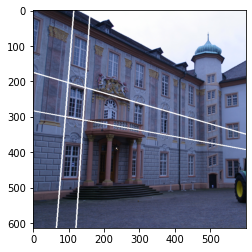

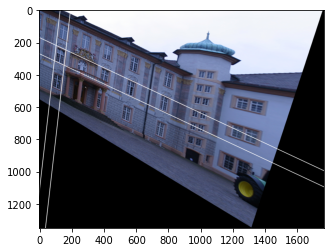

In [ ]:
# Load image and lines
img_name = '0001_s'

img_path = f"../../Data/{img_name}.png"
I = Image.open(img_path)

lines_path = f"../../Data/{img_name}_info_lines.txt"
A = np.loadtxt(lines_path)

def get_line_from_index(i):
    """
    simple function to get a line from its index
    """
    #account for zero indexing
    i = i-1
    p1 = [A[i, 0], A[i, 1], 1] # initial point in line i
    p2 = [A[i, 2], A[i, 3], 1] # final point in line i
    l = np.cross(p1, p2)
    l = l/l[2]
    return l

# compute lines

#l1 and m1 are perpendicular in real world
l1 = get_line_from_index(315)
m1 = get_line_from_index(170)

#l2 and m2 are perpendicular in real world
l2 = get_line_from_index(337)
m2 = get_line_from_index(301)

# Compute two vanishing points
#l1 and l2 are parallel in real world
#m1 and m2 are parallel in real world
vanish_pt1 = np.cross(l1, l2)
vanish_pt2 = np.cross(m1, m2)
vanish_pt1 /= vanish_pt1[2]
vanish_pt2 /= vanish_pt2[2]

# Compute and normalise line at infinity
line_inf = np.cross(vanish_pt1, vanish_pt2)
line_inf /= line_inf[2]

# Construct Homography which maps line_inf to [0, 0, 1]. We assume Ha is the identity.
H_affine_rect = np.array([[1, 0, 0],
                          [0, 1, 0],
                          [line_inf[0], line_inf[1], line_inf[2]]])

# Crops image and applies the homography
I = I.crop((0,0,600,614))
I_aff_rect = apply_H(np.array(I), H_affine_rect)

# Get transformed lines 
H_aff_rect_lines = np.transpose(LA.inv(H_affine_rect))

def normalize_line(l):
    return l/l[2]

def normalize_lines(lines):
    return [normalize_line(line) for line in lines]

lr1 = normalize_line(H_aff_rect_lines@l1)
lr2 = normalize_line(H_aff_rect_lines@l2)
mr1 = normalize_line(H_aff_rect_lines@m1)
mr2 = normalize_line(H_aff_rect_lines@m2)

def draw_with_lines(Img, lines:List):
    Img = Image.fromarray(Img)
    canv = ImageDraw.Draw(Img)
    point_color = (0, 0, 255)
    for line in lines:
        line_draw(line, canv, Img.size)
    plot_img(Img)

draw_with_lines(np.array(I), [l1, m1, m2, l2])
draw_with_lines(I_aff_rect,[lr1,mr1,mr2,lr2])

In [ ]:
print('Angles before transform')
print('θ(l1,l2) = ', get_angle_lines(l1, l2))
print('θ(m1,m2) = ', get_angle_lines(m1, m2))
print('θ(l1,m1) = ', get_angle_lines(l1, m1))

print('Angles after transform')
print('θ(l1,l2) = ', get_angle_lines(lr1, lr2))
print('θ(m1,m2) = ', get_angle_lines(mr1, mr2))
print('θ(l1,m1) = ', get_angle_lines(lr1, mr1))

Angles before transform
θ(l1,l2) =  0.8248639539963791
θ(m1,m2) =  5.951507398707482
θ(l1,m1) =  95.69258991892056
Angles after transform
θ(l1,l2) =  0.0
θ(m1,m2) =  0.0
θ(l1,m1) =  108.49569042748789


We can now proceed to metric rectification.

Even if we already have two pairs of orthogonal lines, those are also parallel to each other. This would lead to a linear dependency on the constraint equations, hence new lines are selected.

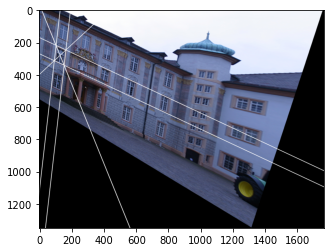

In [ ]:
#get non-parallel set of orhogonal lines, for this we use the diagonals
# from the square window
# get diagonal points in clockwise directin
dp1 = np.cross(lr1,mr1)
dp2 = np.cross(lr2,mr1)
dp3 = np.cross(lr2,mr2)
dp4 = np.cross(lr1,mr2)

diag1 = np.cross(dp1,dp3)
diag2 = np.cross(dp2,dp4)

#normalize them
diag1 /= diag1[2]
diag2 /= diag2[2]

draw_with_lines(I_aff_rect,[lr1,lr2,mr1,mr2,diag1,diag2])

Indeed, the selected lines are pairwise orthogonal while being not-parallel to the rest of lines

Angles before metric rectification
θ(l1,l2) =  0.0
θ(m1,m2) =  0.0
θ(l1,m1) =  108.49569042748789
Angles after metric rectification
θ(l1,l2) =  1.2074182697257333e-06
θ(m1,m2) =  nan
θ(l1,m1) =  90.00000000000001
/work/MCV-M4-3DV/lab1/utils.py:55: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(orth_l.dot(m)/np.sqrt(orth_l.dot(orth_l)*orth_m.dot(orth_m)))


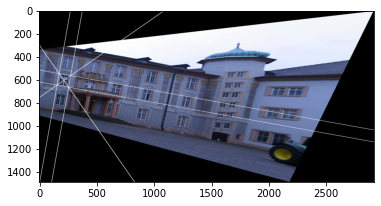

In [ ]:
# Constructing constraint matrix
eq1 = np.array([lr1[0]*mr1[0],
                lr1[0]*mr1[1] + lr1[1]*mr1[0],
                lr1[1]*mr1[1]])

eq2 = np.array([diag1[0]*diag2[0],
                diag1[0]*diag2[1] + diag1[1]*diag2[0],
                diag1[1]*diag2[1]])
eq1 /= eq1[2]
eq2 /= eq2[2]

Eq = np.array([eq1, eq2])

# Computing null_space and constructing the S matrix
S = null_space(Eq)
s = S[:,0]
AA = np.array([[s[0], s[1]], [s[1], s[2]]])

# Getting homography matrix
K = cholesky(AA,lower=True)
Hmetr = build_affine_matrix(K,[0,0])
H = np.linalg.inv(Hmetr)

#applying rectification
I_met_rect = apply_H(I_aff_rect, H)
I_met_rect = crop(I_met_rect)

lrr1, mrr1, lrr2, mrr2, diagr1, diagr2 = normalize_lines(transform_lines(H, I_aff_rect, [lr1, mr1, lr2, mr2, diag1, diag2]))

draw_with_lines(I_met_rect,[lrr1,lrr2,mrr1,mrr2,diagr1,diagr2])

print('Angles before metric rectification')
print('θ(l1,l2) = ', get_angle_lines(lr1, lr2))
print('θ(m1,m2) = ', get_angle_lines(mr1, mr2))
print('θ(l1,m1) = ', get_angle_lines(lr1, mr1))

print('Angles after metric rectification')
print('θ(l1,l2) = ', get_angle_lines(lrr1, lrr2))
print('θ(m1,m2) = ', get_angle_lines(mrr1, mrr2))
print('θ(l1,m1) = ', get_angle_lines(lrr1, mrr1))

The lines are not at their correct place because the origin has been shifted 
because of the way apply_H is implemented. Since the right corner is above the left corner,
the origin gets shifted. This shift is not due to the homography matrix as (0,0) still maps to (0,0) in new coordinates

## **5. OPTIONAL: Metric Rectification in a single step**

<span style='color:Green'> - Write the code that performs metric rectification in a single step (algorithm pages 55-57, Hartley-Zisserman book). </span>

Note: Use 5 pairs of orthogonal lines. You may consider that windows are square.

In [ ]:
# load images and lines
img_path = "../../Data/0001_s.png"
I = Image.open(img_path)

lines_path = "../../Data/0001_s_info_lines.txt"
A = np.loadtxt(lines_path)

l1 = get_line_from_index(511)
m1 = get_line_from_index(802)

l2 = get_line_from_index(424)
m2 = get_line_from_index(766)

# get diagonal points in clockwise directin
dp1 = np.cross(l1,m1)
dp2 = np.cross(l1,m2)
dp3 = np.cross(l2,m2)
dp4 = np.cross(l2,m1)

diag1 = np.cross(dp1,dp3); diag1 = diag1/diag1[2]
diag2 = np.cross(dp2,dp4); diag2 = diag2/diag2[2]

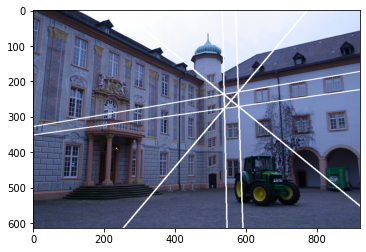

In [ ]:
draw_with_lines(np.array(I),[l1,l2,m1,m2,diag1,diag2])

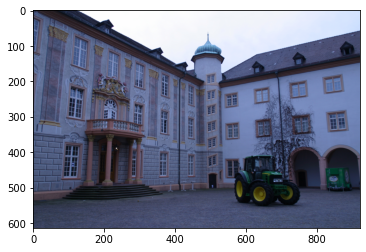

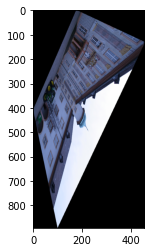

In [ ]:
def get_constraint_array(l, m):
    array = np.array([l[0]*m[0], 
                    (l[0]*m[1]+l[1]*m[0])/2,
                     l[1]*m[1],
                    (l[0]*m[2]+l[2]*m[0])/2,
                    (l[1]*m[2]+l[2]*m[1])/2,
                     l[2]*m[2]])
    return array/array[5]

eq1 = get_constraint_array(l1,m1)
eq2 = get_constraint_array(l1,m2)
eq3 = get_constraint_array(l2,m1)
eq4 = get_constraint_array(l2,m2)
eq5 = get_constraint_array(diag1,diag2)
Eq = np.array([eq1, eq2, eq3, eq4, eq5])

S = null_space(Eq);

s = S[:,0]
a = s[0];b = s[1];c = s[2];d = s[3];e = s[4];f = s[5]

C = np.array([[a, b/2, d/2], [b/2, c, e/2], [d/2, e/2, f]])

U,D,Vt = np.linalg.svd(C)
H = U

Im = apply_H(np.array(I), H)

plot_img(I)
plot_img(Im)

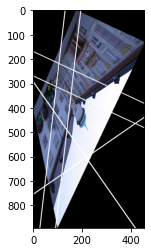

In [ ]:
draw_with_lines(Im,[lr1,lr2,mr1,mr2,diagr1,diagr2])

In [ ]:
lr1, mr1, lr2, mr2, diagr1, diagr2 = transform_lines(H, np.array(I), [l1, m1, l2, m2, diag1, diag2])

print('Angles before transform')
print('θ(l1,l2) = ', get_angle_lines(l1, l2))
print('θ(m1,m2) = ', get_angle_lines(m1, m2))
print('θ(l1,m1) = ', get_angle_lines(l1, m1))
print('θ(diag1,diag2) = ', get_angle_lines(diag1, diag2))

print('Angles after transform')
print('θ(l1,l2) = ', get_angle_lines(lr1, lr2))
print('θ(m1,m2) = ', get_angle_lines(mr1, mr2))
print('θ(l1,m1) = ', get_angle_lines(lr1, mr1))
print('θ(diag1,diag2) = ', get_angle_lines(diagr1, diagr2))


Angles before transform
θ(l1,l2) =  1.5822835494841931
θ(m1,m2) =  0.7277030099012793
θ(l1,m1) =  81.70194635067101
θ(diag1,diag2) =  90.94471948072511
Angles after transform
θ(l1,l2) =  1.117553901738214
θ(m1,m2) =  1.4209530928448038
θ(l1,m1) =  135.65425359799062
θ(diag1,diag2) =  78.6340566229348


Let's try another set of lines

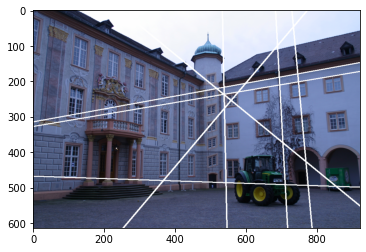

In [ ]:
l1 = get_line_from_index(511)
m1 = get_line_from_index(802)

l2 = get_line_from_index(424)
m2 = get_line_from_index(766)

l3 = get_line_from_index(190)#house-top
m3 = get_line_from_index(256)#pipe

l4 = get_line_from_index(962)
m4 = get_line_from_index(975)

# get diagonal points in clockwise directin
dp1 = np.cross(l1,m1)
dp2 = np.cross(l1,m2)
dp3 = np.cross(l2,m2)
dp4 = np.cross(l2,m1)

diag1 = np.cross(dp1,dp3)
diag2 = np.cross(dp2,dp4)

diag1 = diag1/diag1[2]
diag2 = diag2/diag2[2]

draw_with_lines(np.array(I),[l1,m1,l3,m3,l4,m4,diag1,diag2])

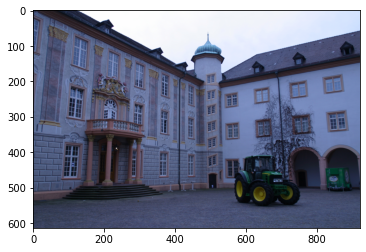

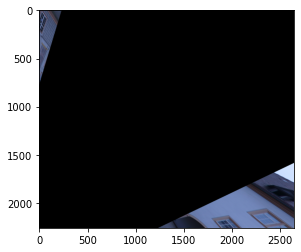

In [ ]:
eq1 = get_constraint_array(l1,m1)
eq2 = get_constraint_array(l1,m2)
eq3 = get_constraint_array(l3,m3)
eq4 = get_constraint_array(l4,m4)
eq5 = get_constraint_array(diag1,diag2)
Eq = np.array([eq1, eq2, eq3, eq4, eq5])

S = null_space(Eq);

s = S[:,0]
a = s[0];b = s[1];c = s[2];d = s[3];e = s[4];f = s[5]

C = np.array([[a, b/2, d/2], [b/2, c, e/2], [d/2, e/2, f]])

U,D,Vt = np.linalg.svd(C)
H = U

Im = apply_H(np.array(I), H)

plot_img(I)
plot_img(Im)

In [ ]:
lr1, mr1, lr2, mr2, diagr1, diagr2 = transform_lines(H, np.array(I), [l1, m1, l2, m2, diag1, diag2])

print('Angles before transform')
print('θ(l1,l2) = ', get_angle_lines(l1, l2))
print('θ(m1,m2) = ', get_angle_lines(m1, m2))
print('θ(l1,m1) = ', get_angle_lines(l1, m1))
print('θ(diag1,diag2) = ', get_angle_lines(diag1, diag2))

print('Angles after transform')
print('θ(l1,l2) = ', get_angle_lines(lr1, lr2))
print('θ(m1,m2) = ', get_angle_lines(mr1, mr2))
print('θ(l1,m1) = ', get_angle_lines(lr1, mr1))
print('θ(diag1,diag2) = ', get_angle_lines(diagr1, diagr2))

Angles before transform
θ(l1,l2) =  1.5822835494841931
θ(m1,m2) =  0.7277030099012793
θ(l1,m1) =  81.70194635067101
θ(diag1,diag2) =  90.94471948072511
Angles after transform
θ(l1,l2) =  3.8543283110107294
θ(m1,m2) =  10.564627983238129
θ(l1,m1) =  25.203236968225468
θ(diag1,diag2) =  166.48466441670783
